# Assignment 2

In [173]:
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import torch.nn as nn
import torch.nn.functional as F
from sklearn.preprocessing import MinMaxScaler,OneHotEncoder
import torch.optim as optim
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore")

plt.ion()   # interactive mode

## Task 1 
1. Write a custom dataset class for the titanic data (see the data folder on GitHub).
2. Use only the features: "Pclass", "Age", "SibSp", "Parch", „Fare“, „Sex“, „Embarked“.
3. Preprocess the features accordingly in that class (scaling, one-hot-encoding, etc) and
4. split the data into train and validation data (80% and 20%). The constructor of that class
should look like this:
```
titanic_train = TitanicDataSet('titanic.csv', train=True)
titanic_val = TitanicDataSet('titanic.csv', train=False)
```

In [174]:
# share variables
D_in, D_out = 10, 1 
num_epochs = 250 
log_interval = 100 

# batch_size 
batch_size = 30

# learning rate
learning_rate = 0.001
multi_learning_rate = 0.001

# hidden layers 
multi_num_layers = 6

# hidden neurons
neurons = 3 
multi_neurons = 1024 

In [175]:
class TitanicDataset(Dataset):

    # data loading and preprocessing
    def __init__(self, root_dir, train=True, transform=None):
        self.train = train
        self.transform = transform
        minmax_scaler = MinMaxScaler()
        onehot_enc = OneHotEncoder()

        titanic = pd.read_csv(root_dir)
        titanic = titanic[["Pclass", "Age", "SibSp", "Parch", "Fare", "Sex", "Embarked", "Survived"]]

        titanic["Age"] = titanic["Age"].fillna(titanic["Age"].mean())
        titanic = titanic.dropna()
        titanic = titanic.reset_index(drop=True)

        categorical_features = titanic[titanic.select_dtypes(include=['object']).columns.tolist()]
        numerical_features = titanic[titanic.select_dtypes(exclude=['object']).columns].drop('Survived', axis=1)
        label_features = titanic['Survived']

        numerical_features_arr = minmax_scaler.fit_transform(numerical_features)
        categorical_features_arr = onehot_enc.fit_transform(categorical_features).toarray()

        combined_features = pd.DataFrame(data=numerical_features_arr, columns=numerical_features.columns)
        combined_features = pd.concat([combined_features, pd.DataFrame(data=categorical_features_arr)], axis=1)
        combined_features = pd.concat([combined_features, label_features], axis=1).reset_index(drop=True)

        train_data, test_data = train_test_split(combined_features, test_size=0.2, random_state=42)

        if train:
            self.data = train_data
        else:
            self.data = test_data

    def __len__(self):
        return len(self.data)

    # for neural network when training
    def __getitem__(self, idx):
        sample = self.data.iloc[idx]
        features = torch.FloatTensor(sample[:-1])
        label = torch.FloatTensor([sample['Survived']])
        if self.transform:
            features = self.transform(features)
        return features, label
    
    # get dataframe from dataset
    def getData(self):
        return self.data


In [176]:
titanic_train = TitanicDataset('./data/titanic.csv', train=True)
titanic_val = TitanicDataset('./data/titanic.csv', train=False)
print('train_dataset len:', len(titanic_train))
print('val_dataset len:', len(titanic_val))
print('total_dataset len:', len(titanic_train) + len(titanic_val))

train_dataset len: 711
val_dataset len: 178
total_dataset len: 889


In [177]:
titanic_val.getData()

,Pclass,Age,SibSp,Parch,Fare,0,1,2,3,4,Survived
280,1.0,0.346569,0.000,0.000000,0.015330,0.0,1.0,0.0,0.0,1.0,0
434,0.0,0.170646,0.125,0.333333,0.234224,1.0,0.0,0.0,0.0,1.0,1
39,1.0,0.170646,0.125,0.000000,0.021942,1.0,0.0,1.0,0.0,0.0,1
417,0.5,0.371701,0.000,0.000000,0.025374,0.0,1.0,0.0,0.0,1.0,0
584,0.0,0.220910,0.000,0.333333,0.155466,1.0,0.0,0.0,0.0,1.0,1
...,...,...,...,...,...,...,...,...,...,...,...
432,1.0,0.208344,0.000,0.000000,0.013907,0.0,1.0,0.0,0.0,1.0,0
806,1.0,0.220910,0.000,0.000000,0.015176,1.0,0.0,0.0,0.0,1.0,0
25,1.0,0.472229,0.125,0.833333,0.061264,1.0,0.0,0.0,0.0,1.0,1
84,1.0,0.409399,0.375,0.000000,0.030937,1.0,0.0,0.0,0.0,1.0,1


## Task 2 
Build a neural network with: 
1. one hidden layer of size 3 that predicts the survival of the
passengers. 
2. Use a BCE loss (Hint: you need a sigmoid activation in the output layer).
3. Use a data loader to train in batches of size 16 and shuffle the data.


# Task 4 
- Increase the complexity of the network by adding more layers and neurons and see if you can overfit on the training data.

# Task 5 
- Try to remove overfitting by introducing a dropout layer.


### Note
- You can remvoe the following comment relative to dropout to achieve better results 

In [188]:
class MultiLayerNet(nn.Module):
    def __init__(self, D_in, D_out, neurons, num_layers, dropout_prob=0.8):
        super(MultiLayerNet, self).__init__()
        neurons = neurons
        self.input = nn.Linear(D_in, neurons)
        self.linears = nn.ModuleList()  
        # self.dropouts = nn.ModuleList() 
        for i in range(num_layers):
            self.linears.append(nn.Linear(neurons, max(neurons // 2, 16)))
            # self.dropouts.append(nn.Dropout(p=dropout_prob))
            neurons = max(neurons // 2, 16) 
        self.output = nn.Linear(neurons, D_out) 
        self.sigmoid = nn.Sigmoid()  
    def forward(self, x):
        y = F.relu(self.input(x))
        # for layer, dropout in zip(self.linears, self.dropouts):
        for layer in self.linears:
            y = F.relu(layer(y))
            # y = dropout(y) 
        y_pred = self.sigmoid(self.output(y))
        return y_pred

In [179]:
class TwoLayerNet(nn.Module):
    def __init__(self, D_in, H, D_out):
        """
        In the constructor we instantiate two nn.Linear modules and assign them as member variables.
        """
        super(TwoLayerNet, self).__init__()
        # the weight and bias of linear1 will be initialized 
        # you can access them by self.linear1.weight and self.linear1.bias
        self.linear1 = nn.Linear(D_in, H) # this will create weight, bias for linear1
        self.linear2 = nn.Linear(H, D_out) # this will create weight, bias for linear2
        self.sigmoid = nn.Sigmoid() # Sigmoid activation for binary classification

    def forward(self, x):
        """
        In the forward function we accept a Tensor of input data and we must return a Tensor of output data.
        We can use Modules defined in the constructor as well as arbitrary operators on Tensors.
        """
        h_relu = F.relu(self.linear1(x))
        y_pred = self.sigmoid(self.linear2(h_relu))
        return y_pred

In [189]:
# Load Data
train_dataloader = DataLoader(titanic_train, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(titanic_val, batch_size=batch_size, shuffle=True)

# Build up Networks 
network = TwoLayerNet(D_in, neurons, D_out) 
multi_network = MultiLayerNet(D_in, D_out, multi_neurons, multi_num_layers) 

# Define Optimizer 
optimizer = optim.Adam(network.parameters(), learning_rate)
multi_optimizer = optim.Adam(multi_network.parameters(), multi_learning_rate)

# Define Loss Function
criterion = nn.BCELoss() 
multi_criterion = nn.BCELoss()


# Task 3 
- Evaluate the performance of the model on the validation data using accuracy as metric.

In [190]:
train_losses = [] 
train_counter = [] 
test_losses = [] 
test_counter = [i*len(titanic_train) for i in range(num_epochs+1)] 

- Two Layer Network and Multi Layer Network Training Functions

In [191]:

def train_multi(epoch):
    multi_network.train()
    correct = 0
    cur_count = 0 

    for batch_idx, (data, target) in enumerate(train_dataloader):
        multi_optimizer.zero_grad()
        optimizer.zero_grad()
        
        # forward propagation
        output = multi_network(data)
        loss = multi_criterion(output, target)
                
        # Accuracy
        pred = (output >= 0.5).float() 
        correct += (pred == target).sum().item()
        cur_count += len(data)

        # backword propagation
        loss.backward()
        multi_optimizer.step()
        

        if batch_idx % log_interval == 0:
            print('Muti Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}\t Accuracy: {}/{} ({:.0f}%)'.format(
                epoch, 
                cur_count, 
                len(train_dataloader.dataset),
                100. * cur_count / len(train_dataloader.dataset), 
                loss.item(), 
                correct, len(train_dataloader.dataset),
                100. * correct / len(train_dataloader.dataset))
            )
            train_losses.append(loss.item())
            train_counter.append((batch_idx*16) + ((epoch-1)*len(train_dataloader.dataset)))
            
    return correct / len(train_dataloader.dataset)


In [192]:

def train(epoch):
    network.train()
    correct = 0
    cur_count = 0 

    for batch_idx, (data, target) in enumerate(train_dataloader):
        optimizer.zero_grad()
        
        # forward propagation
        output = network(data)
        loss = criterion(output, target)
                
        # Accuracy
        pred = (output >= 0.5).float()  # survival_rate is the threshold
        correct += (pred == target).sum().item()
        cur_count += len(data)

        # backword propagation
        loss.backward()
        optimizer.step()
        

        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}\t Accuracy: {}/{} ({:.0f}%)'.format(
                epoch, 
                cur_count, 
                len(train_dataloader.dataset),
                100. * cur_count / len(train_dataloader.dataset), 
                loss.item(), 
                correct, len(train_dataloader.dataset),
                100. * correct / len(train_dataloader.dataset))
            )
            train_losses.append(loss.item())
            train_counter.append((batch_idx*16) + ((epoch-1)*len(train_dataloader.dataset)))
            
    return correct / len(train_dataloader.dataset)


- Two Layer Network and Multi Layer Network Testing Function

In [193]:
def test():
    network.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_dataloader:
            # forward propagation
            output = network(data)
            test_loss += criterion(output, target).item()
            # Accuracy
            pred = (output >= 0.5).float()  # 0.5 is the threshold
            correct += (pred == target).sum().item()
    test_loss /= len(test_dataloader.dataset)
    test_losses.append(test_loss)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, 
        correct, 
        len(test_dataloader.dataset),
        100. * correct / len(test_dataloader.dataset))
    )
    return correct / len(test_dataloader.dataset)

In [194]:
def test_multi():
    multi_network.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_dataloader:
            # forward propagation
            output = multi_network(data)
            test_loss += multi_criterion(output, target).item()
            # Accuracy
            pred = (output >= 0.5).float()  # 0.5 is the threshold
            correct += (pred == target).sum().item()
    test_loss /= len(test_dataloader.dataset)
    test_losses.append(test_loss)
    print('\nMulti Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, 
        correct, 
        len(test_dataloader.dataset),
        100. * correct / len(test_dataloader.dataset))
    )
    return correct / len(test_dataloader.dataset)

- Start Training and Testing
- You can remove the comment below to see "Two Layer Network Training and Testing Result" 

In [195]:
# test()
test_multi()

# train_accuracy_list = []
# test_accuracy_list = []
multi_train_accuracy_list = []
multi_test_accuracy_list = []

for epoch in range(1, num_epochs + 1):
    # train_accuracy_list.append(train(epoch))
    # test_accuracy_list.append(test())

    multi_train_accuracy_list.append(train_multi(epoch))
    multi_test_accuracy_list.append(test_multi())


Multi Test set: Average loss: 0.0229, Accuracy: 109/178 (61%)

Muti Train Epoch: 1 [30/711 (4%)]	Loss: 0.686389	 Accuracy: 16/711 (2%)

Multi Test set: Average loss: 0.0229, Accuracy: 109/178 (61%)

Muti Train Epoch: 2 [30/711 (4%)]	Loss: 0.648679	 Accuracy: 18/711 (3%)

Multi Test set: Average loss: 0.0228, Accuracy: 109/178 (61%)

Muti Train Epoch: 3 [30/711 (4%)]	Loss: 0.639967	 Accuracy: 16/711 (2%)

Multi Test set: Average loss: 0.0228, Accuracy: 109/178 (61%)

Muti Train Epoch: 4 [30/711 (4%)]	Loss: 0.690428	 Accuracy: 20/711 (3%)

Multi Test set: Average loss: 0.0228, Accuracy: 109/178 (61%)

Muti Train Epoch: 5 [30/711 (4%)]	Loss: 0.727130	 Accuracy: 18/711 (3%)

Multi Test set: Average loss: 0.0227, Accuracy: 109/178 (61%)

Muti Train Epoch: 6 [30/711 (4%)]	Loss: 0.633677	 Accuracy: 16/711 (2%)

Multi Test set: Average loss: 0.0227, Accuracy: 109/178 (61%)

Muti Train Epoch: 7 [30/711 (4%)]	Loss: 0.656519	 Accuracy: 16/711 (2%)

Multi Test set: Average loss: 0.0227, Accuracy:

# Task 4 
- Create the following plot that was introduced in the lecture.

# Task 5 
- Increase the complexity of the network by adding more layers and neurons and see if you can overfit on the training data.

Text(0, 0.5, 'Accuracy')

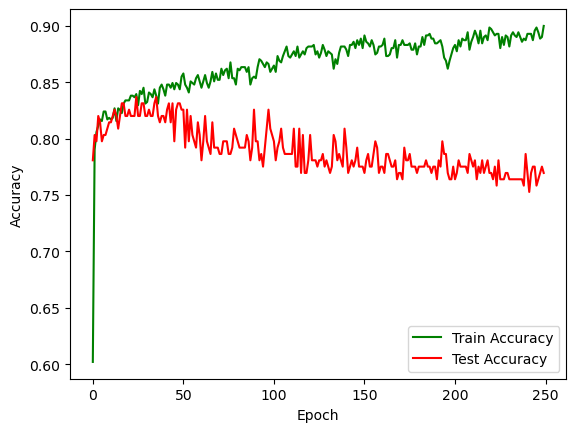

In [187]:
import matplotlib.pyplot as plt
# plt.plot(train_accuracy_list, color='blue')
# plt.plot(test_accuracy_list, color='red')
plt.plot(multi_train_accuracy_list, color='green')
plt.plot(multi_test_accuracy_list, color='red')
# plt.ylim(0.725, 1)
plt.legend(['Train Accuracy', 'Test Accuracy', 'Mutli Train Accuracy', 'Mutli Test Accuracy'], loc='lower right')
plt.xlabel('Epoch (Before Dropout)')
plt.ylabel('Accuracy')

# Task 6 
- Try to remove overfitting by introducing a dropout layer.


Text(0, 0.5, 'Accuracy')

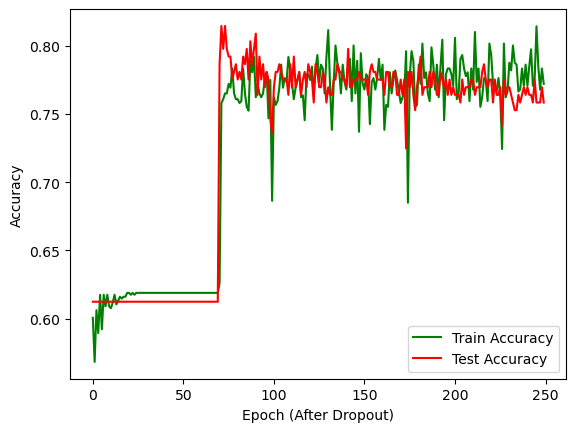

In [196]:
import matplotlib.pyplot as plt
# plt.plot(train_accuracy_list, color='blue')
# plt.plot(test_accuracy_list, color='red')
plt.plot(multi_train_accuracy_list, color='green')
plt.plot(multi_test_accuracy_list, color='red')
# plt.ylim(0.725, 1)
plt.legend(['Train Accuracy', 'Test Accuracy', 'Mutli Train Accuracy', 'Mutli Test Accuracy'], loc='lower right')
plt.xlabel('Epoch (After Dropout)')
plt.ylabel('Accuracy')